# Introduction

This competition is about the prediction of Russian house prices. In this dataset, we have house related information as well as the russian economic data. It is a really good challenge to play with the housing dataset and linking it with a country's econnomy. Both of these dataset can be joined together by date column. We have lots of missing values in both dataset. But I will use xgboost algorithm which will take care of missing values on its own.

This dataset can be used to enhance regression skills, feature enginnering, and preprocessing. This data is available at [this link](https://www.kaggle.com/c/sberbank-russian-housing-market/overview).

In [1]:
library(ggplot2)
library(caret)
library(tidyverse)
library(lubridate)
library(xgboost)
library(plyr)
library(MASS)
library(psych)
library(png)
options(repr.matrix.max.cols= 500)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: lattice
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice

------------------------------------------------------------------------------
You have loaded plyr af

Lets set the working directory.

In [2]:
setwd("C:\\Users\\uzair\\Codes\\Russian Market Price")

In [3]:
train = read.csv('train.csv', stringsAsFactors = FALSE)
test = read.csv('test.csv', stringsAsFactors = FALSE)
macros = read.csv('macro.csv', stringsAsFactors = FALSE)

## View the dataset

In [4]:
head(train)

id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,X0_6_all,X0_6_male,X0_6_female,X7_14_all,X7_14_male,X7_14_female,X0_17_all,X0_17_male,X0_17_female,X16_29_all,X16_29_male,X16_29_female,X0_13_all,X0_13_male,X0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921.1945,build_count_1946.1970,build_count_1971.1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_200

In [5]:
nas = colSums(is.na(train))
nas = nas[nas > 0]
nas = sort(nas, decreasing = TRUE)
head(nas)

hospital_beds_raion                 build_year 
                     14441                      13605 
                     state cafe_sum_500_min_price_avg 
                     13559                      13281 
cafe_sum_500_max_price_avg         cafe_avg_price_500 
                     13281                      13281

In [6]:
dim(train)

[1] 30471   292

In [7]:
dim(test)

[1] 7662  291

## Data Visualization

### Distribution

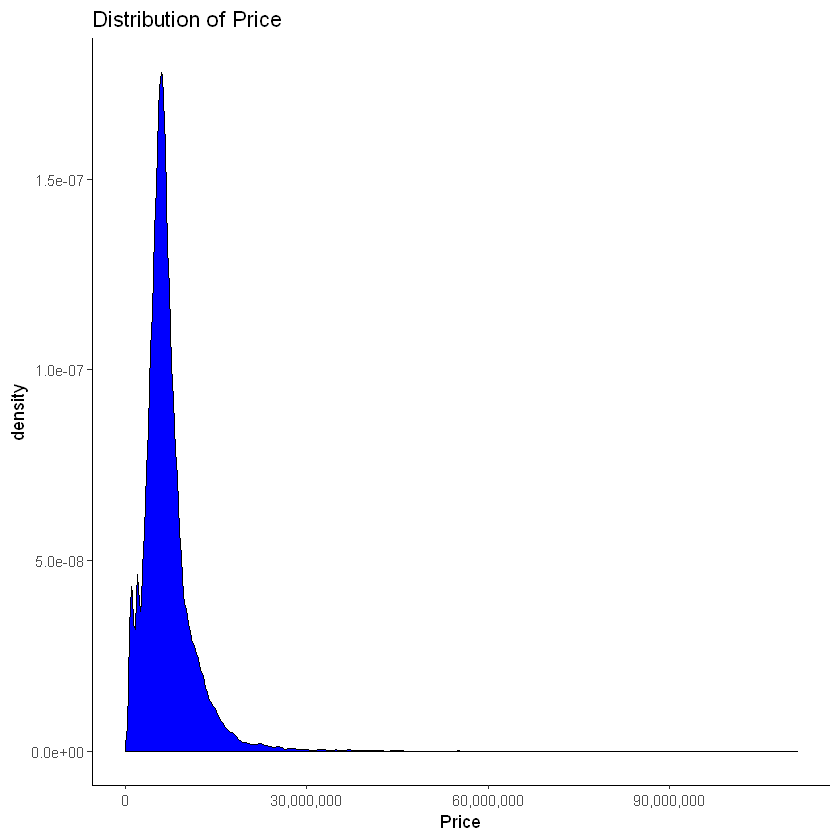

In [8]:
ggplot(train, aes(x = price_doc)) +
geom_density(fill = 'blue') +
theme_classic() +
xlab("Price") +
ggtitle("Distribution of Price") +
scale_x_continuous(labels = scales::comma)

Our target variable is positively skewed. I will use log transformation to see whether it will fix this problem. Lets visualize the result of log transformation in order to find out whether this method will help or not.

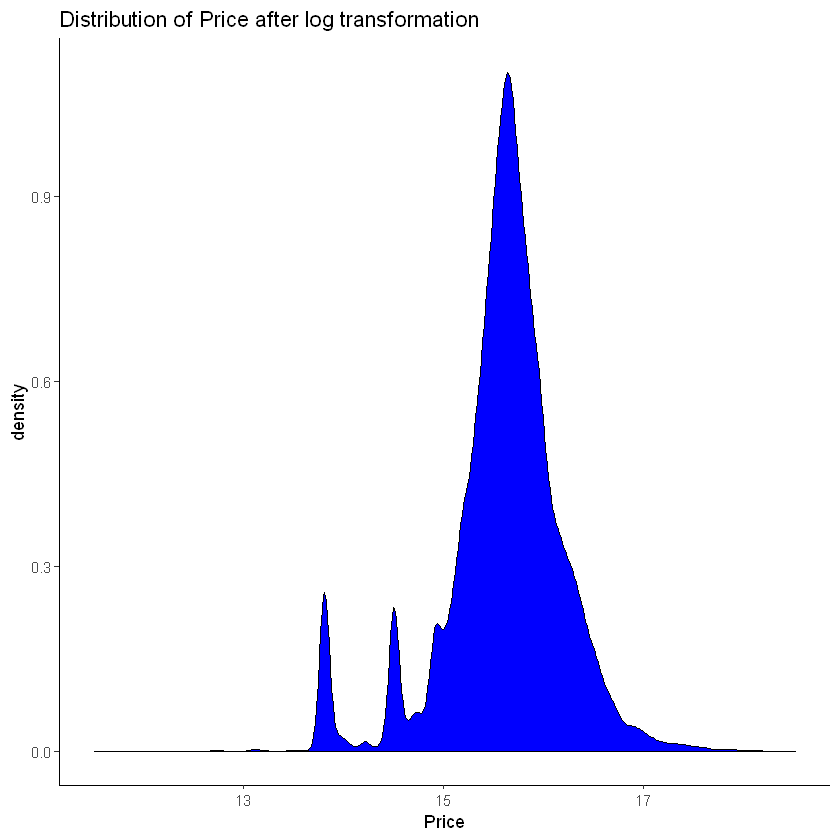

In [9]:
ggplot(train, aes(x = log(price_doc))) +
geom_density(fill = 'blue') +
theme_classic() +
xlab("Price") +
ggtitle("Distribution of Price after log transformation") +
scale_x_continuous(labels = scales::comma)

The distribution of price is closer to normal distribution after log transformation.

## Merging Train and Test

In [10]:
test$price_doc = NA

data = rbind(train, test)

head(data)

id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,X0_6_all,X0_6_male,X0_6_female,X7_14_all,X7_14_male,X7_14_female,X0_17_all,X0_17_male,X0_17_female,X16_29_all,X16_29_male,X16_29_female,X0_13_all,X0_13_male,X0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921.1945,build_count_1946.1970,build_count_1971.1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_200

In [11]:
str(data)

'data.frame':	38133 obs. of  292 variables:
 $ id                                   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ timestamp                            : chr  "2011-08-20" "2011-08-23" "2011-08-27" "2011-09-01" ...
 $ full_sq                              : num  43 34 43 89 77 67 25 44 42 36 ...
 $ life_sq                              : num  27 19 29 50 77 46 14 44 27 21 ...
 $ floor                                : int  4 3 2 9 4 14 10 5 5 9 ...
 $ max_floor                            : int  NA NA NA NA NA NA NA NA NA NA ...
 $ material                             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ build_year                           : int  NA NA NA NA NA NA NA NA NA NA ...
 $ num_room                             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ kitch_sq                             : num  NA NA NA NA NA NA NA NA NA NA ...
 $ state                                : int  NA NA NA NA NA NA NA NA NA NA ...
 $ product_type                         : chr  "Investment" 

## Getting Year, Month and Day from timestamp
I will use famous lubridate package to extract year, month and day as it is way easier than the any other package available in R.

In [12]:
data$Date = ymd(data$timestamp)
data$Year = year(data$Date)
data$Month = month(data$Date)
data$Day = day(data$Date)
head(data)

id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,X0_6_all,X0_6_male,X0_6_female,X7_14_all,X7_14_male,X7_14_female,X0_17_all,X0_17_male,X0_17_female,X16_29_all,X16_29_male,X16_29_female,X0_13_all,X0_13_male,X0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921.1945,build_count_1946.1970,build_count_1971.1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_200

## Data Transformation
We have a few columns that are actually numeric but they are converted to strings due to the presence of comma ",". In order to fix this issue, I will remove comma between those numbers and convert them back to numeric.

### Joining macros with data

In [13]:
merged_data = left_join(data, macros, by = "timestamp")

merged_data$child_on_acc_pre_school <- as.numeric(gsub(",","",merged_data$child_on_acc_pre_school))
merged_data$modern_education_share <- as.numeric(gsub(",","",merged_data$modern_education_share))
merged_data$old_education_build_share <- as.numeric(gsub(",","",merged_data$old_education_build_share))
head(merged_data)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,X0_6_all,X0_6_male,X0_6_female,X7_14_all,X7_14_male,X7_14_female,X0_17_all,X0_17_male,X0_17_female,X16_29_all,X16_29_male,X16_29_female,X0_13_all,X0_13_male,X0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921.1945,build_count_1946.1970,build_count_1971.1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_200

#### Mode Imputation
As we dont have any information about product type column, I will impute mode in missing values.

In [14]:
merged_data$product_type[is.na(merged_data$product_type)] = names(sort(-table(merged_data$product_type)))[1]

## Double checking nas
any(is.na(merged_data$product_type))

[1] FALSE

####  Encoding
Converting all the columns with yes and no values into 1 and 0 repectively.

In [15]:
merged_data$culture_objects_top_25 = ifelse(merged_data$culture_objects_top_25 == "yes", 1, 0)
merged_data$thermal_power_plant_raion = ifelse(merged_data$thermal_power_plant_raion == "yes", 1, 0)
merged_data$incineration_raion = ifelse(merged_data$incineration_raion == "yes", 1, 0)
merged_data$oil_chemistry_raion = ifelse(merged_data$oil_chemistry_raion == "yes", 1, 0)
merged_data$radiation_raion = ifelse(merged_data$radiation_raion == "yes", 1, 0)
merged_data$railroad_terminal_raion = ifelse(merged_data$railroad_terminal_raion == "yes", 1, 0)
merged_data$big_market_raion = ifelse(merged_data$big_market_raion == "yes", 1, 0)
merged_data$nuclear_reactor_raion = ifelse(merged_data$nuclear_reactor_raion == "yes", 1, 0)
merged_data$detention_facility_raion = ifelse(merged_data$detention_facility_raion == "yes", 1, 0)
merged_data$water_1line = ifelse(merged_data$water_1line == "yes", 1, 0)
merged_data$railroad_1line = ifelse(merged_data$railroad_1line == "yes", 1, 0)
merged_data$big_road1_1line = ifelse(merged_data$big_road1_1line == "yes", 1, 0)
head(merged_data)

id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,X0_6_all,X0_6_male,X0_6_female,X7_14_all,X7_14_male,X7_14_female,X0_17_all,X0_17_male,X0_17_female,X16_29_all,X16_29_male,X16_29_female,X0_13_all,X0_13_male,X0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921.1945,build_count_1946.1970,build_count_1971.1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_200

In [16]:
table(merged_data$ecology)


   excellent         good      no data         poor satisfactory 
        5164         8785         9421        10078         4685 

#### Label Encoding
As ecology is an ordinal variable, I will convert this column into numeric.

In [17]:
number <- c('no data' = 0, 'poor' = 1, 'satisfactory' = 2, 'good' = 3, 'excellent' = 4)
merged_data$ecology = as.integer(revalue(merged_data$ecology, number))
table(merged_data$ecology)


    0     1     2     3     4 
 9421 10078  4685  8785  5164 

In [18]:
## Selecting all numeric columns

final_data = merged_data %>%
select_if(is.numeric)

final_data$price_doc = data$price_doc

## Split the final data
I will use log transformation in order to fix skewness in our target variable i.e. Price_doc

In [19]:
train = final_data[!is.na(final_data$price_doc),]

test = final_data[is.na(final_data$price_doc),]

## log transformation
train$price_doc = log(train$price_doc)
print(dim(train))

print(dim(test))

## Get the number of target column

print(which(colnames(train) == "price_doc"))

[1] 30471   391
[1] 7662  391
[1] 289


## Xgboost
Xgboost is a very powerful algorithm, it will take care of missing values on its own.

In [20]:
set.seed(123)
dtrain = xgb.DMatrix(data = as.matrix(train[, -289]), label = train$price_doc)

params = list(objective = "reg:squarederror",
              booster = "gbtree",
              eta = 0.05,
              max_depth = 4,
              min_child_weight = 1,
              subsample = 1,
              colsample_bytree = 1, 
              gamma = 1)

In order to avoid overfitting of our model, I will use early stopping rounds, which will see whether the results are improving in our validation folds. Our model will automatically stop training when it doesnt see any improvement. 

In [21]:
cv_results = xgb.cv(params = params,
                    data = dtrain,
                    nrounds = 500,
                    early_stopping_rounds = 20,
                    maximize = FALSE,
                    print_every_n = 100,
                    nfold = 5,
                    metrics = "rmse"
       
)

[1]	train-rmse:14.366563+0.001171	test-rmse:14.366564+0.004905 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[101]	train-rmse:0.458078+0.002582	test-rmse:0.475121+0.008956 
[201]	train-rmse:0.431542+0.002918	test-rmse:0.462194+0.010475 
[301]	train-rmse:0.419129+0.003705	test-rmse:0.460833+0.010762 
Stopping. Best iteration:
[355]	train-rmse:0.412982+0.003608	test-rmse:0.460583+0.010862



In [22]:
model_xgb = xgb.train(params = params,data = dtrain,
                      watchlist = list(train = dtrain),
                     nrounds = cv_results$best_iteration,
                     print_every_n = 10,
                     early_stopping_rounds = 20,
                     maximize = F)

[1]	train-rmse:14.366540 
Will train until train_rmse hasn't improved in 20 rounds.

[11]	train-rmse:8.612225 
[21]	train-rmse:5.172215 
[31]	train-rmse:3.121177 
[41]	train-rmse:1.907147 
[51]	train-rmse:1.201945 
[61]	train-rmse:0.809774 
[71]	train-rmse:0.608603 
[81]	train-rmse:0.516049 
[91]	train-rmse:0.476934 
[101]	train-rmse:0.460572 
[111]	train-rmse:0.453260 
[121]	train-rmse:0.449418 
[131]	train-rmse:0.447085 
[141]	train-rmse:0.444883 
[151]	train-rmse:0.443211 
[161]	train-rmse:0.441479 
[171]	train-rmse:0.440058 
[181]	train-rmse:0.438903 
[191]	train-rmse:0.437686 
[201]	train-rmse:0.436415 
[211]	train-rmse:0.435065 
[221]	train-rmse:0.433833 
[231]	train-rmse:0.432750 
[241]	train-rmse:0.431634 
[251]	train-rmse:0.430495 
[261]	train-rmse:0.429463 
[271]	train-rmse:0.428179 
[281]	train-rmse:0.427398 
[291]	train-rmse:0.426308 
[301]	train-rmse:0.425261 
[311]	train-rmse:0.424341 
[321]	train-rmse:0.423450 
[331]	train-rmse:0.422524 
[341]	train-rmse:0.421721 
[351]	

With a little more preprocessing and fixing outliers, we can get better results

In [23]:
results = predict(model_xgb, newdata = as.matrix(test[, - 289]))
prediction = exp(results)

In [24]:
submission = read.csv('sample_submission.csv')
submission$price_doc = prediction
write.csv(submission, 'sub.csv', row.names = F)

**Final result in the competition is 0.34 rmse :)**